# Applied Data Science Capstone Project

## This notebook will be mainly used for the capstone project.

In [29]:
import pandas as pd
import numpy as np
print ("Hello Capstone Project Course!")

Hello Capstone Project Course!


# Week 3 Graded Assignment Start

In [6]:
#!pip install watson-developer-cloud==1.5
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes #install folium

     |████████████████████████████████| 225kB 2.0MB/s eta 0:00:01
     |████████████████████████████████| 778kB 51.2MB/s eta 0:00:01
     |████████████████████████████████| 3.1MB 48.5MB/s eta 0:00:01
     |████████████████████████████████| 2.3MB 27.3MB/s eta 0:00:01
     |████████████████████████████████| 174kB 50.2MB/s eta 0:00:01
     |████████████████████████████████| 61kB 14.2MB/s eta 0:00:01
     |████████████████████████████████| 102kB 34.8MB/s ta 0:00:01
     |████████████████████████████████| 81kB 31.4MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/81/cd/de/4e0916f623c2d125502e493394fd333ed693960264d4b7e524
  Stored in directory: /home/dsxuser/.cache/pip/wheels/19/4c/a1/0bef832134076abab3461815e92cf41f2518dffe1a5337203b
Successfully built watson-developer-cloud Twisted
  Found existing installation: cryptography 2.5
    Uninstalling cryptography-2.5:
      Successfully uninstalled cryptography-2.5


In [126]:
from bs4 import BeautifulSoup
import requests
wiki_text = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text

In [128]:
df_table = pd.read_html(wiki_text, header = 0)[0]
df_table.head()

Postcode           Borough     Neighbourhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront

In [129]:
# removes every row with a 'Not Assigned' listing for Borough
df_table = df_table[df_table.Borough != 'Not assigned']
df_table.head()

Postcode           Borough     Neighbourhood
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront
5      M5A  Downtown Toronto       Regent Park
6      M6A        North York  Lawrence Heights

In [130]:
# More than one neighborhood can exist in one postal code area.
# Postcodes with more than 1 neighborhood will be combined into 1 postcode with multiple neighborhoods
df_table = df_table.groupby(['Postcode','Borough'], sort=False).agg( ', '.join).reset_index()
df_table.head()

Postcode           Borough                     Neighbourhood
0      M3A        North York                         Parkwoods
1      M4A        North York                  Victoria Village
2      M5A  Downtown Toronto         Harbourfront, Regent Park
3      M6A        North York  Lawrence Heights, Lawrence Manor
4      M7A      Queen's Park                      Not assigned

In [131]:
# If a cell has a borough but a 'Not assigned' neighborhood, then the neighborhood will be the same as the borough. 
df_table.loc[result['Neighbourhood'] =='Not assigned' , 'Neighbourhood'] = df_table['Borough']
df_table.head()

Postcode           Borough                     Neighbourhood
0      M3A        North York                         Parkwoods
1      M4A        North York                  Victoria Village
2      M5A  Downtown Toronto         Harbourfront, Regent Park
3      M6A        North York  Lawrence Heights, Lawrence Manor
4      M7A      Queen's Park                      Not assigned

In [132]:
df_table.shape

(103, 3)

In [133]:
#To obtain  the geographical coordinates of each postal code from csv file
!wget -q -O 'Toronto_long_lat_data.csv'  http://cocl.us/Geospatial_data
df_Lat_Long = pd.read_csv('Toronto_long_lat_data.csv')
df_Lat_Long.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [134]:
df_Lat_Long.columns=['Postcode','Latitude','Longitude'] # csv data 

#Merging Lat/Long data with dataframe of postal codes, boroughs, and neighborhoods
df_locations = pd.merge(df_table,
                 df_Lat_Long[['Postcode','Latitude', 'Longitude']],
                 on='Postcode')
df_locations.head()

Postcode           Borough                     Neighbourhood   Latitude  \
0      M3A        North York                         Parkwoods  43.753259   
1      M4A        North York                  Victoria Village  43.725882   
2      M5A  Downtown Toronto         Harbourfront, Regent Park  43.654260   
3      M6A        North York  Lawrence Heights, Lawrence Manor  43.718518   
4      M7A      Queen's Park                      Not assigned  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [111]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from sklearn 
from sklearn.cluster import KMeans
import folium # map rendering library

Libraries imported.


In [135]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude_toronto = location.latitude
longitude_toronto = location.longitude
print('The geograpical coordinates of Toronto are Latitude {} and Longitude {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinates of Toronto are Latitude 43.653963, and Longitude -79.387207.


In [138]:
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, borough, Neighbourhood in zip(df_locations['Latitude'], df_locations['Longitude'], df_locations['Borough'], df_locations['Neighbourhood']):
    label = '{}, {}'.format(Neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

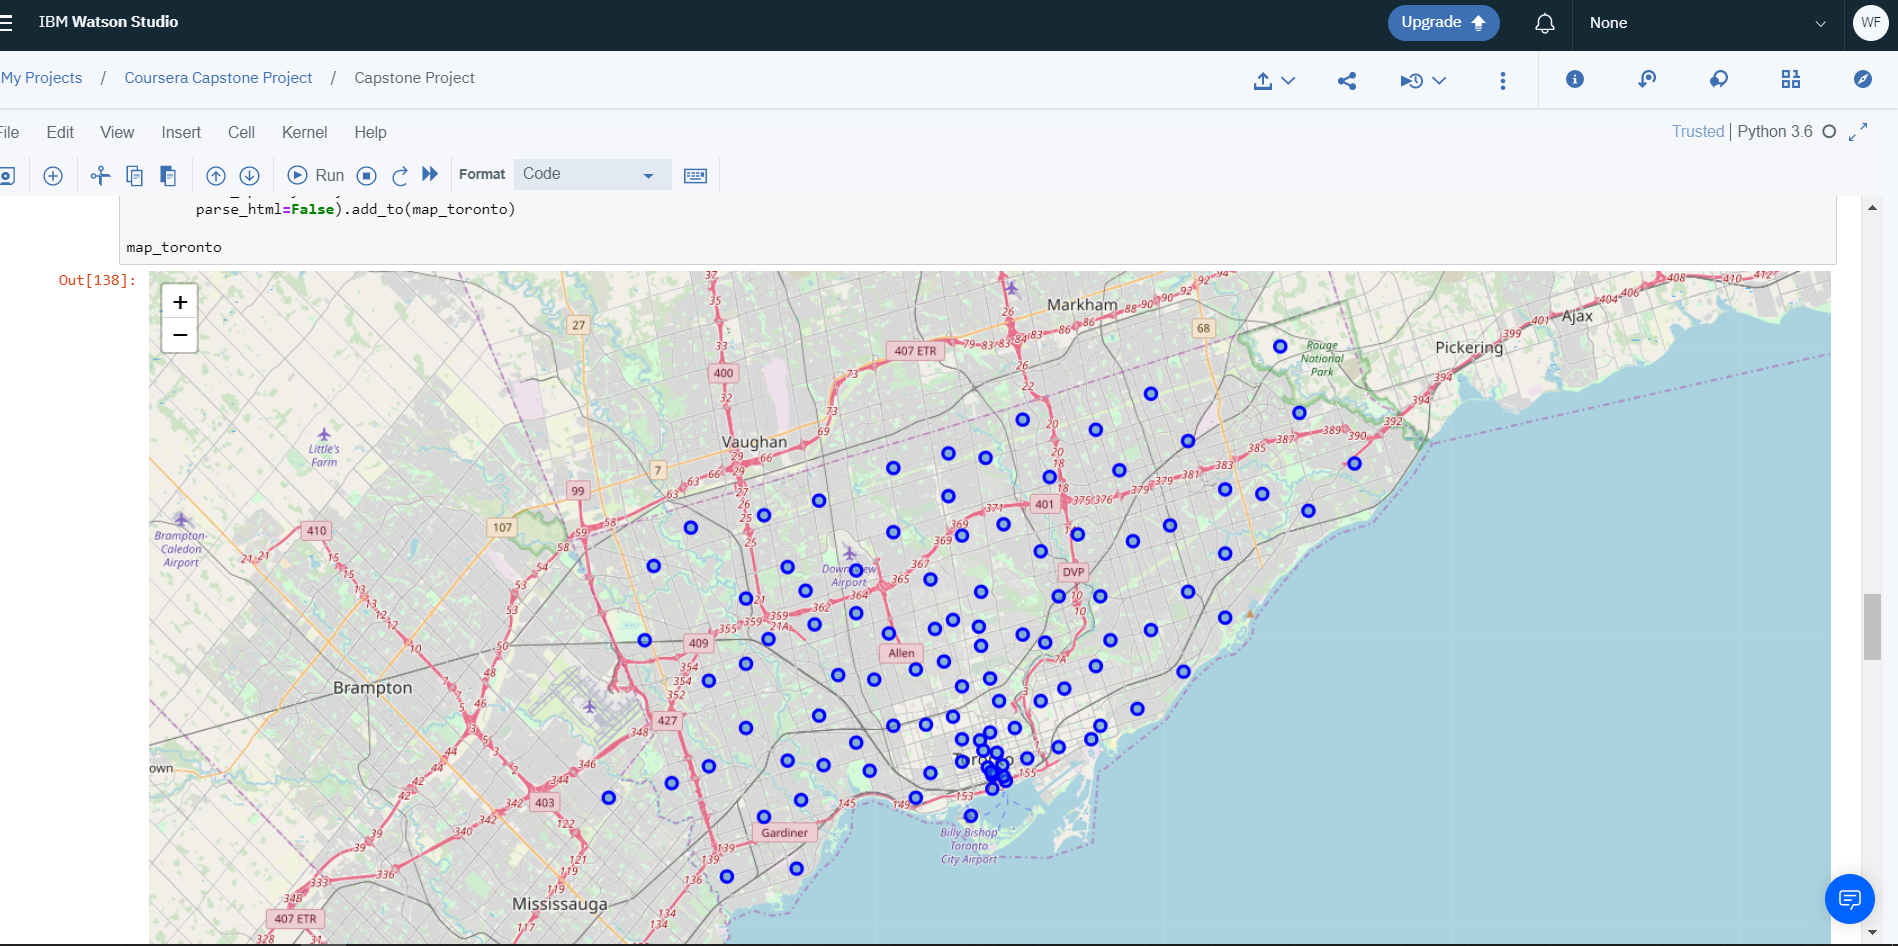

In [150]:
# set number of clusters
kclusters = 5

df_locations_cluster = df_locations.drop('Neighbourhood', 1)
df_locations_cluster = df_locations_cluster.drop('Borough', 1)
df_locations_cluster = df_locations_cluster.drop('Postcode', 1)
#df_locations_cluster.head()
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_locations_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 2, 3, 2, 1, 0, 4, 4, 2], dtype=int32)

In [168]:
cluster_labels = pd.DataFrame(kmeans.labels_)[0]
cluster_labels.head(5)

0    4
1    4
2    2
3    3
4    2
Name: 0, dtype: int32

In [169]:
df_locations['Cluster']=cluster_labels

In [172]:
df_locations=pd.DataFrame(df_locations)
df_locations.head()

Postcode           Borough                     Neighbourhood   Latitude  \
0      M3A        North York                         Parkwoods  43.753259   
1      M4A        North York                  Victoria Village  43.725882   
2      M5A  Downtown Toronto         Harbourfront, Regent Park  43.654260   
3      M6A        North York  Lawrence Heights, Lawrence Manor  43.718518   
4      M7A      Queen's Park                      Not assigned  43.662301   

   Longitude  Cluster  
0 -79.329656        4  
1 -79.315572        4  
2 -79.360636        2  
3 -79.464763        3  
4 -79.389494        2

In [175]:
# create map
map_clusters = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_locations['Latitude'], df_locations['Longitude'], df_locations['Neighbourhood'], df_locations['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

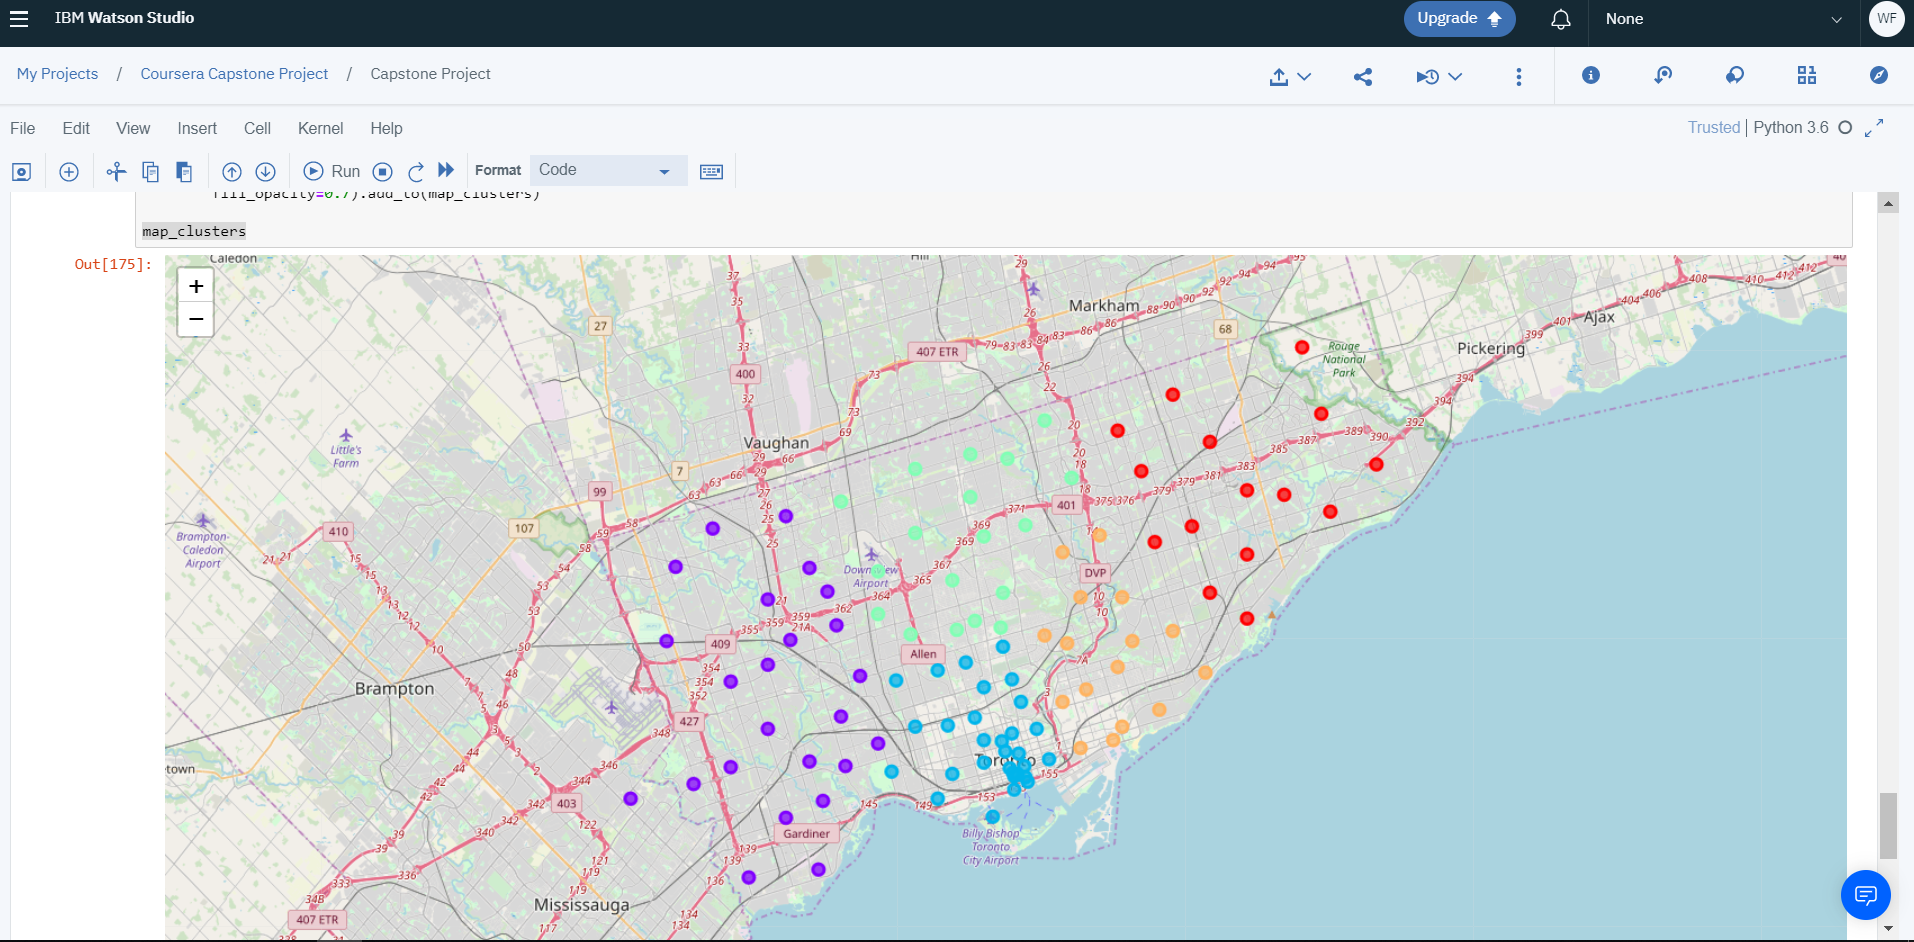